In [1]:
import os, time, math, glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [16]:
# Constants definition
IMAGE_SIZE = (64, 64)
N_CHANNELS = 3
BATCH_SIZE = 64
NUM_EXAMPLES = 1
NORM_FACTOR = 255. / 2
EPOCHS = 200
LATENT_DIMS = 100

In [3]:
# Load dataset
dataset_path = "dataset/art-paintings"

train_ds = keras.utils.image_dataset_from_directory(
    directory=dataset_path, 
    image_size=IMAGE_SIZE,
    seed=101,
    shuffle=True,
    batch_size=BATCH_SIZE
)

train_ds

Found 8231 files belonging to 1 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

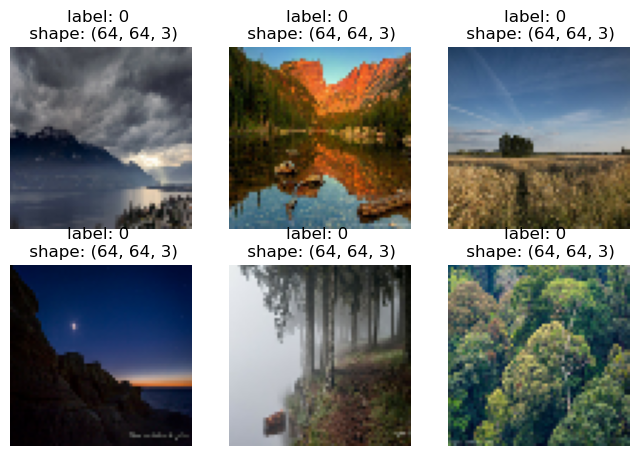

In [4]:
# Visualize sample images
plt.figure(figsize=(8, 8), dpi=100)
for (x, y) in train_ds.take(1):
    for i in range(6):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x[i].numpy().astype('uint8'))
        plt.title(f'label: {y[i].numpy()} \n shape: {x[i].numpy().shape}')
        plt.axis('off')

In [5]:
# Preprocess images
def preprocess(data, label):
    data = tf.image.resize(data, IMAGE_SIZE)
    return ((data - NORM_FACTOR) / NORM_FACTOR, label)

def deprocess(data):
    return data * NORM_FACTOR + NORM_FACTOR

train_ds = train_ds.map(preprocess).prefetch(1).cache()

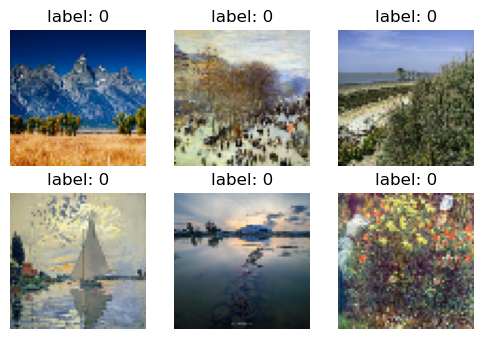

In [6]:
# Visualize preprocessed images
plt.figure(figsize=(6, 6), dpi=100)

for (x, y) in train_ds.take(1):
    for i in range(0, 6):
        img = x[i]
        label = y[i]
        plt.subplot(3, 3, i + 1)
        plt.imshow(deprocess(img.numpy()).astype(np.uint8))
        plt.title(f'label: {label}')
        plt.axis('off')

In [7]:
# GAN model
class GAN():
    def __init__(self, latent_dims, input_shape, batch_size, training_size=None):
        self.latent_dims = latent_dims
        self.image_shape = input_shape
        self.batch_size = batch_size
        self.training_size = training_size
        
        self.cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)
        
        self.generator_optimizer = keras.optimizers.Adam(3e-4)
        self.discriminator_optimizer = keras.optimizers.Adam(3e-4)
        
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
    
    def build_generator(self):
        model = keras.Sequential([
            keras.layers.Dense(4 * 4 * 512, input_shape=(self.latent_dims, )),
            keras.layers.BatchNormalization(),
            keras.layers.LeakyReLU(),
            keras.layers.Reshape((4, 4, 512)),
            keras.layers.Conv2DTranspose(256, (5, 5), strides=2, padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.LeakyReLU(),
            keras.layers.Conv2DTranspose(128, (5, 5), strides=2, padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.LeakyReLU(),
            keras.layers.Conv2DTranspose(64, (5, 5), strides=2, padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.LeakyReLU(),
            keras.layers.Conv2DTranspose(32, (5, 5), strides=2, padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.LeakyReLU(),
            keras.layers.Conv2DTranspose(3, (5, 5), strides=1, padding='same', activation='tanh')
        ])
        return model
    
    def build_discriminator(self):
        model = keras.Sequential([
            keras.layers.Conv2D(64, (5, 5), strides=2, padding='same', input_shape=self.image_shape),
            keras.layers.LeakyReLU(),
            keras.layers.Dropout(0.3),
            keras.layers.Conv2D(128, (5, 5), strides=2, padding='same'),
            keras.layers.LeakyReLU(),
            keras.layers.Dropout(0.3),
            keras.layers.Conv2D(256, (5, 5), strides=2, padding='same'),
            keras.layers.LeakyReLU(),
            keras.layers.Dropout(0.3),
            keras.layers.Flatten(),
            keras.layers.Dense(1)
        ])
        return model
    
    def generator_loss(self, fakes):
        return self.cross_entropy(tf.ones_like(fakes), fakes)
    
    def discriminator_loss(self, reals, fakes):
        real_loss = self.cross_entropy(tf.ones_like(reals), reals)
        fake_loss = self.cross_entropy(tf.zeros_like(fakes), fakes)
        return real_loss + fake_loss
    
    @tf.function
    def train_step(self, images):
        noise = tf.random.normal(shape=(self.batch_size, self.latent_dims))
        
        with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
            generated_images = self.generator(noise, training=True)
            
            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            
            generator_loss = self.generator_loss(fakes=fake_output)
            discriminator_loss = self.discriminator_loss(reals=real_output, fakes=fake_output)
            
        generator_gradients = generator_tape.gradient(generator_loss, self.generator.trainable_variables)
        discriminator_gradients = discriminator_tape.gradient(discriminator_loss, self.discriminator.trainable_variables)
        
        self.generator_optimizer.apply_gradients(zip(generator_gradients, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(discriminator_gradients, self.discriminator.trainable_variables))
    
    def get_checkpoint_callback(self):
        checkpoint = tf.train.Checkpoint(
            generator_optimizer=self.generator_optimizer,
            discriminator_optimizer=self.discriminator_optimizer,
            generator=self.generator,
            discriminator=self.discriminator
        )
        return checkpoint
    
    def train(self, dataset, epochs, seed, load_from_checkpoint=False):
        start_training = time.time()
        for epoch in range(1, epochs + 1):
            start = time.time()
            for batch_idx, (image_batch, _) in enumerate(dataset):
                self.train_step(image_batch)
                if self.training_size is not None:
                    print(f'Batch: {batch_idx+1}/{math.ceil(self.training_size/self.batch_size)}')
            end = time.time()
            print(f'Epoch: {epoch}/{epochs} | Time: {math.ceil(end - start)} seconds')
        end_training = time.time()  
        print(f'Training duration: {math.ceil(end_training - start_training)} seconds')
        return True

In [8]:
# Random starting seed
seed = tf.random.normal([NUM_EXAMPLES, LATENT_DIMS])

In [17]:
# Initialize a GAN model
gan = GAN(
    latent_dims=LATENT_DIMS, 
    input_shape=IMAGE_SIZE + (N_CHANNELS, ), 
    batch_size=BATCH_SIZE
)

In [18]:
gan.generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8192)              827392    
                                                                 
 batch_normalization_5 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 8, 8, 256)        3277056   
 ranspose)                                                       
                                                                 
 batch_normalization_6 (Batc  (None, 8, 8, 256)       

In [19]:
gan.discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 dropout_3 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 256)        

In [20]:
# Train gan
gan.train(dataset=train_ds, epochs=EPOCHS, seed=seed)

Epoch: 1/200 | Time: 10 seconds
Epoch: 2/200 | Time: 7 seconds
Epoch: 3/200 | Time: 7 seconds
Epoch: 4/200 | Time: 8 seconds
Epoch: 5/200 | Time: 8 seconds
Epoch: 6/200 | Time: 8 seconds
Epoch: 7/200 | Time: 8 seconds
Epoch: 8/200 | Time: 8 seconds
Epoch: 9/200 | Time: 8 seconds
Epoch: 10/200 | Time: 8 seconds
Epoch: 11/200 | Time: 8 seconds
Epoch: 12/200 | Time: 8 seconds
Epoch: 13/200 | Time: 8 seconds
Epoch: 14/200 | Time: 8 seconds
Epoch: 15/200 | Time: 8 seconds
Epoch: 16/200 | Time: 8 seconds
Epoch: 17/200 | Time: 8 seconds
Epoch: 18/200 | Time: 8 seconds
Epoch: 19/200 | Time: 8 seconds
Epoch: 20/200 | Time: 8 seconds
Epoch: 21/200 | Time: 8 seconds
Epoch: 22/200 | Time: 8 seconds
Epoch: 23/200 | Time: 8 seconds
Epoch: 24/200 | Time: 8 seconds
Epoch: 25/200 | Time: 8 seconds
Epoch: 26/200 | Time: 8 seconds
Epoch: 27/200 | Time: 8 seconds
Epoch: 28/200 | Time: 8 seconds
Epoch: 29/200 | Time: 8 seconds
Epoch: 30/200 | Time: 8 seconds
Epoch: 31/200 | Time: 8 seconds
Epoch: 32/200 | 

True

1/1 [==============================] - 1s 700ms/step


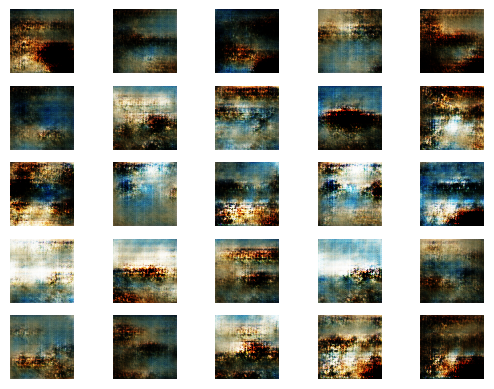

In [23]:
# Plot some images
n = 25
noise = np.random.normal(size=(n, LATENT_DIMS))
examples = gan.generator.predict(noise)

for i in range(n):
    plt.subplot(int(math.sqrt(n)), int(math.sqrt(n)), i+1)
    plt.axis("off")
    plt.imshow(deprocess(examples[i]).astype(np.uint8))
plt.show()